# NOTE
### In this notebook, we used another dataset (MedWeb) to further validate our conclusion, this is another classification work. Use patients' reviews to predict satisfaction level (1,2,3,4,5,6) for their drugs.

In [1]:
from data_utils import generateMedWeb
train_loader, val_loader, test_loader = generateMedWeb(dataPath='./dataset/webmd.csv')
print("length of train loader: {}".format(len(train_loader)))
print("length of val loader: {}".format(len(val_loader)))

length of train loader: 7021
length of val loader: 1505


In [2]:
next(iter(train_loader))

[tensor([[  101,  1045,  2572,  ...,  2781,  1010,  2048],
         [  101,  1996,  4200,  ...,     0,     0,     0],
         [  101,  2074,  2318,  ...,  2000,  6036,  1005],
         ...,
         [  101,  2053,  3471,  ...,  2000,  5589,  1012],
         [  101,  1045,  2001,  ..., 24798,  2000,  4293],
         [  101,  2057,  6914,  ...,     0,     0,     0]], dtype=torch.int32),
 tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 tensor([3, 0, 0, 0, 0, 4, 3, 1, 3, 4, 0, 0, 4, 3, 4, 4, 0, 0, 0, 4, 0, 0, 4, 3,
         2, 3, 3, 2, 4, 3, 2, 2])]

# Fine tuning BERT

In [3]:
from transformers import AdamW, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
model.cuda()
print(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [4]:
import torch
from train_epoch import evaluate
import torch.nn as nn
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
from transformers import get_linear_schedule_with_warmup
from train_epoch import train, evaluate, bert_predict

epochs = 2
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()
total_steps = len(train_loader) * epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_losses, val_losses, val_acc = train(model, loss_fn, optimizer, scheduler, train_loader, val_loader, epochs=epochs, evaluation=True, device=device, FINETUNE=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   200   |   1.357823   |     -      |     -     |   36.90  
   1    |   400   |   1.202183   |     -      |     -     |   35.10  
   1    |   600   |   1.167344   |     -      |     -     |   35.24  
   1    |   800   |   1.134662   |     -      |     -     |   35.35  
   1    |  1000   |   1.131025   |     -      |     -     |   35.37  
   1    |  1200   |   1.106156   |     -      |     -     |   35.42  
   1    |  1400   |   1.109517   |     -      |     -     |   35.50  
   1    |  1600   |   1.081820   |     -      |     -     |   35.50  
   1    |  1800   |   1.080154   |     -      |     -     |   35.52  
   1    |  2000   |   1.058766   |     -      |     -     |   35.57  
   1    |  2200   |   1.068554   |     -      |     -     |   35.55  
   1    |  2400   |   1.054206   |     -      |     -     |   35.56  


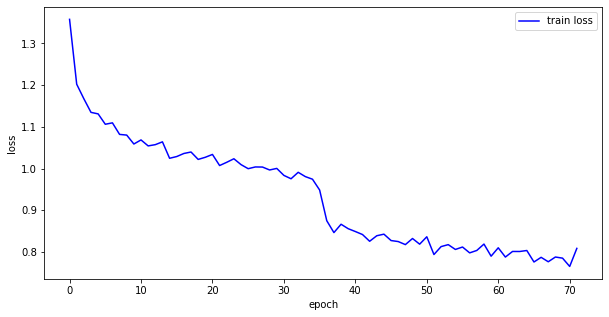

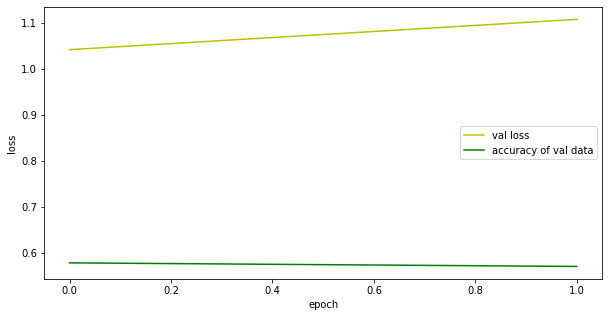

In [6]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train loss", c='b')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(val_losses, label="val loss", c='y')
plt.plot(val_acc, label="accuracy of val data", c='g')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# Test on Model (Finetune BERT)

In [7]:
label = [i for i in range(6)]

def bertPredict(model, b_input_ids, b_attn_mask, FINETUNE):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    model.eval()
    with torch.no_grad():
        logits = model(b_input_ids, b_attn_mask)
        if FINETUNE:
            logits = logits["logits"]
    preds = torch.argmax(logits, dim=1).flatten()
    predictions = []
    for pred in preds.cpu().numpy():
        predictions.append(label[pred])
    return predictions

def evaluateRandomly(model, test_dataloader, n=1, FINETUNE=False):
    for i, sample in enumerate(test_dataloader):
        if i > n: break
            
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in sample)
        predict = bertPredict(model, b_input_ids, b_attn_mask, FINETUNE)
        b_labels = b_labels.cpu().numpy()
        for i, pred in enumerate(b_labels):
            print("label: {} --- predict: {}".format(label[b_labels[i]], predict[i]))

In [8]:
from train_epoch import evaluate

test_loss, test_acc = evaluate(model, loss_fn, test_loader, device=device, FINETUNE=True)
print("Accuracy on test dataset: {}".format(test_acc))
evaluateRandomly(model, test_loader, FINETUNE=True)

Accuracy on test dataset: 58.90691741813004
label: 2 --- predict: 0
label: 0 --- predict: 0
label: 4 --- predict: 3
label: 2 --- predict: 0
label: 2 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 3
label: 2 --- predict: 0
label: 4 --- predict: 4
label: 0 --- predict: 0
label: 1 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 3
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 2
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 2
label: 1 --- predict: 1
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 3 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 1
label: 0 --- predict: 0
label: 4 --- predict: 4
label: 4 --- predict

# Remove Layer 12 in BERT

In [9]:
from load_model import BertClassifier
from train_epoch import train, evaluate, bert_predict
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
import torch.nn as nn
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BertClassifier(freeze_bert=False, D_out=6)
print(model)
model.to(device)
epochs = 2

optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()
total_steps = len(train_loader) * epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [10]:
print(device)
train_losses, val_losses, val_acc = train(model, loss_fn, optimizer, scheduler, train_loader, val_loader, epochs=epochs, evaluation=True, device=device)

cuda:0
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   200   |   1.358726   |     -      |     -     |   32.92  
   1    |   400   |   1.177259   |     -      |     -     |   32.85  
   1    |   600   |   1.143835   |     -      |     -     |   32.86  
   1    |   800   |   1.156068   |     -      |     -     |   32.82  
   1    |  1000   |   1.129289   |     -      |     -     |   32.84  
   1    |  1200   |   1.119059   |     -      |     -     |   32.82  
   1    |  1400   |   1.098391   |     -      |     -     |   32.84  
   1    |  1600   |   1.074706   |     -      |     -     |   32.83  
   1    |  1800   |   1.067808   |     -      |     -     |   32.83  
   1    |  2000   |   1.065901   |     -      |     -     |   32.84  
   1    |  2200   |   1.065404   |     -      |     -     |   32.86  
   1    |  2400   |   1.055403   |     -      |     -     |   3

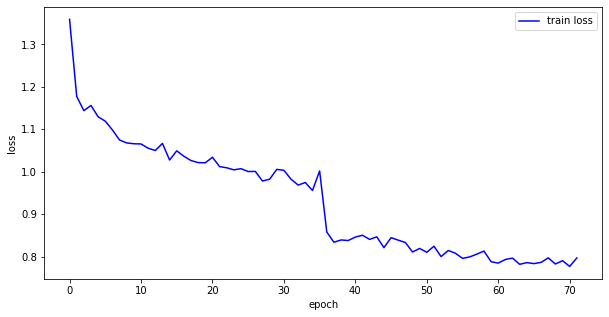

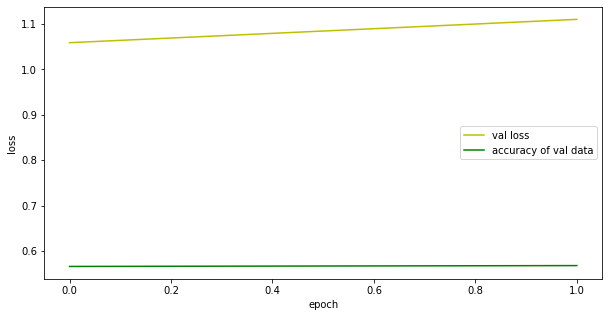

In [11]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train loss", c='b')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(val_losses, label="val loss", c='y')
plt.plot(val_acc, label="accuracy of val data", c='g')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

# Test on Model (remove layer 12)

In [12]:
test_loss, test_acc = evaluate(model, loss_fn, test_loader, device=device, FINETUNE=False)
print("Accuracy on test dataset: {}".format(test_acc))
evaluateRandomly(model, test_loader)

Accuracy on test dataset: 58.66961319411485
label: 2 --- predict: 0
label: 0 --- predict: 0
label: 4 --- predict: 3
label: 2 --- predict: 0
label: 2 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 4
label: 2 --- predict: 0
label: 4 --- predict: 4
label: 0 --- predict: 0
label: 1 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 2
label: 0 --- predict: 4
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 4
label: 0 --- predict: 2
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 1 --- predict: 1
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 3 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 0 --- predict: 0
label: 4 --- predict: 4
label: 4 --- predict